# Telecom: Identifying Ineffective Operators

A virtual telephony service is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have a large number of missed incoming calls (internal and external) and a long waiting time for incoming calls. Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.

Identify ineffective operators based on the number of calls (incoming / outgoing), the waiting time for incoming calls and the number of outgoing calls (if the operator is supposed to make them).

## Outline

### Data Preprocessing
- Study missing values, type correspondence and duplicate values.
- If necessary, remove duplicates, rename columns, convert types. 

### Exploratory Data Analysis

#### Plot pie chart for call length

#### Plot a histogram showing the number of calls per day

#### Plot a pie chart showing the shares of internal and external calls

#### Plot pie chart for tariff plans

#### Plot a histogram showing user registrations per day

#### Analyse incoming calls (for bothinternal and external):
- Calculate average waiting time.
- Compare the average waiting time of the individual operator to the average of all operators.
- Calculate average number of missed calls.
- Compare average missed calls of individual operators to the average of all operators.
- Compare missed calls to the total number of calls.
- Graph missed calls by date.

#### Analyze outgoing calls:
- Calculate the average number of outgoing calls made per operator.
- Compare the average of individual operators to the average of all operators.

#### Determine the number of ineffective operators.

#### Investigate distribution of ineffective operators to tariff plansTest statistical hypotheses

### Testing Hypothesis
- Hypothesis: Average call duration for ineffective operators and effective operators are the same.

### Conclusion
- Describe summary of findings.
- Conclusion: How many operators are ineffective? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime 
import matplotlib.dates
from scipy import stats as st

## Load Data

In [2]:
# Open data files
data = pd.read_csv('/datasets/telecom_dataset_us.csv')

# Study general information
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


This dataset contains information on the clients, the operators and calls between them: 

the user_id column is the clients account ID, 

the data column is the date this information was retreived, 

the direction column is the call direction where out is for outgoing and in is for incoming, 

the internal column is whether the call was internal (between operators) or not, 

the operator_id column is the operator ID, 

the is_missed_cal column is whether the call was missed or not, 

the calls_count column is the number of calls, 

the call_duration column is the duration of the call (excluding waiting time) and 

the total_call_duration is the call duration (including waiting time). 

When observing the data information, there are 53902 total rows but the internal column has 117 missing or null values and operator_id has 8172 missing or null values. 

In [3]:
# Open data files
clients = pd.read_csv('/datasets/telecom_clients_us.csv')

# Study general information
clients.info()
display(clients.head())

# Drop any duplicates in the database
clients.drop_duplicates(inplace=True)

# convert dates to datetime objects, only date should remain
clients['date_start'] = pd.to_datetime(clients['date_start'], format="%Y-%m-%d").dt.date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


This dataset contains information on the client, their tariff plan and the registration date. All data preprocessing was done here directly since this is a smaller data set.

## Preprocess Data

In [4]:
# drop null values for internal and operator_id
data.dropna(subset=['internal', 'operator_id'], inplace=True)

# Drop any duplicates in the database
data.drop_duplicates(inplace=True)

# convert dates to datetime objects, only date should remain
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d").dt.date

# convert operator_id from float to int
data['operator_id'] = data['operator_id'].astype(int)

# rename columns to include units
data = data.rename(columns={'call_duration': 'call_duration_sec', 'total_call_duration': 'total_call_duration_sec'})

When observing the data information, there are 53902 total rows but the internal column has 117 missing or null values and operator_id has 8172 missing or null values. To handle these missing or null values, the only thing there is to do is to drop them because there is no other way to determine or estimate what these values would be. For the internal column, dropping 117 rows does not make a dent on the 53902 rows but the same cannot be said for the operator_id column which is missing more than 8000 values (it is usually not recommended to drop more than 10 percent of rows). After dropping null values, there are 45670 remaining rows and after dropping duplicate rows, there are 41491 remaining rows.

Additionally, I converted the date column to datetime type and dropped the time (since all times were 0), converted the operator_id column from float type to int and added (s) units to call_duration and total_call_durationn columns. 

## Exploratory Data Analysis

###  Plot a pie chart showing the shares of internal and external calls

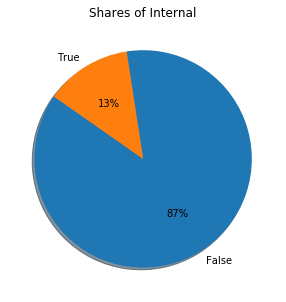

In [5]:
# plot pie chart with proportions
plt.figure(figsize=(10, 5))

internal_external = data.groupby('internal')['operator_id'].count().reset_index()
internal_external.columns = ['internal', 'count']

labels = ['False', 'True']
plt.pie(internal_external['count'], labels=labels, autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Shares of Internal')
plt.show()

The pie chart above shows the shares of internal and external calls found within the data: almost 90 percent of the calls are not internal calls, therefore they are external calls with clients.

### Plot pie chart for call length

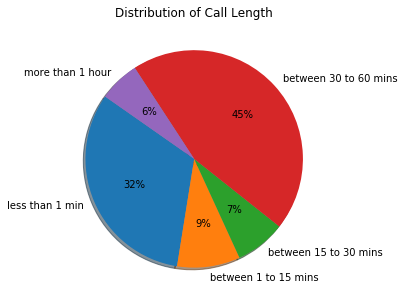

In [6]:
# group rows into call duration categories
def determineCallDurationCategory(row):
    call_duration = row['call_duration_sec']
    
    # 0 to 1 min
    if call_duration <= 60:
        return 'less than 1 min'
    
    # 1 to 15 min
    if 60 < call_duration <= 900:
        return 'between 1 to 15 mins'
    
    # 15 to 30 min
    if 900 < call_duration <= 1800:
        return 'between 15 to 30 mins'
    
    # 30 to 60 min
    if 1800 < call_duration <= 3600:
        return 'between 30 to 60 mins'
    
    # 60+ mins
    if call_duration > 3600:
        return 'more than 1 hour'

# apply result from method to new category
data['call_length_category'] = data.apply(determineCallDurationCategory, axis=1)

# group each category
call_category = data.groupby('call_length_category')['operator_id'].count().reset_index()
call_category.columns = ['call_length_category', 'count']

# plot pie chart with proportions
plt.figure(figsize=(10, 5))

labels = ['less than 1 min', 'between 1 to 15 mins', 'between 15 to 30 mins', 'between 30 to 60 mins', 'more than 1 hour']
plt.pie(call_category['count'], labels=labels,autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Distribution of Call Length')
plt.show()

This pie chart shows the distribution of call lengths found in the data. I broke the categories up into5 categories: a call less than 1 min, between 1 to 15 mins, between 15 to 30 mins, between 30 to 60 mins, and more than 1 hour long. After plotting the distribution of these categories through the data, the chart shows that almost half of the calls are between 30 to 60 mins. The second biggest category are calls that are less than 1 minute long.

### Plot a histogram showing the number of calls per day

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


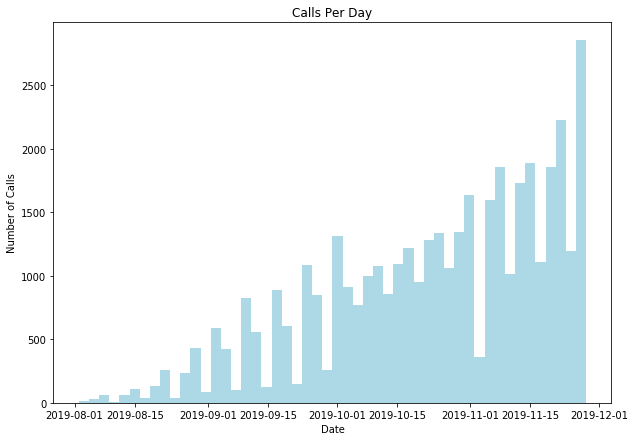

In [7]:
# plot it
fig = plt.figure(figsize=(10,7))

plt.hist(data['date'], bins=50, color='lightblue')
plt.title('Calls Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.show()

After plotting the number of calls per day, the histogram shows an upward trends in number of calls from August of 2019 to late November 2019. It is not clear as to why the number of calls increased so much in a 3 month period but it could be because operators realized they were being monitored by management and decided to step up their productivity. Additionally, it could be because over time there are more registered users and the operators have to make more calls to keep up with demand.

Another interesting point to notice about the histogram is that there are dates where the number of calls is quite high and then the day or few days after, it drops. 

### Plot pie chart for tariff plans

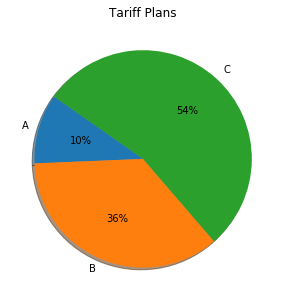

In [8]:
# plot pie chart with proportions
plt.figure(figsize=(10, 5))

tariff = clients.groupby('tariff_plan')['user_id'].count().reset_index()
tariff.columns = ['tariff_plan', 'count']

labels = ['A', 'B', 'C']
plt.pie(tariff['count'], labels=labels, autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Tariff Plans')
plt.show()

From this pie chart, we can see that most users are subscribed to tariff C and the least amount of users are subscribed to tariff A.

### Plot a histogram showing user registrations per day

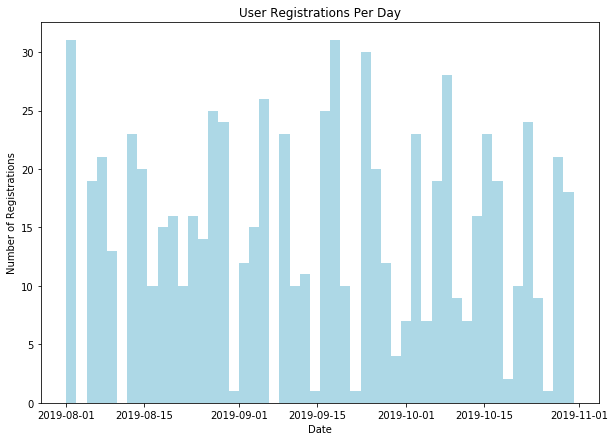

In [9]:
# plot it
fig = plt.figure(figsize=(10,7))

plt.hist(clients['date_start'], bins=50, color='lightblue')

plt.title('User Registrations Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.show()

This histogram shows the number of user regsitration per day over a 3 month period. There seems to be no pattern or steady increase/decrease to the number of registrations. 

### Incoming Calls

#### Calculate average waiting time.

In [10]:
# merge clients dataframe with data dataframe
data = pd.merge(data, clients, on='user_id')

incoming_data = data[data['direction'] == 'in']

# calculate waiting time and add it as a collumn
incoming_data['in_waiting_time_sec'] = incoming_data['total_call_duration_sec'] - incoming_data['call_duration_sec']
avg_waiting_time_incoming_calls = incoming_data['in_waiting_time_sec'].mean().round()
print('The total average waiting time incoming calls: ' + str(avg_waiting_time_incoming_calls) + " seconds")

The total average waiting time incoming calls: 97.0 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


To calculate the average waiting time of incoming calls (both internal and external), I calculated the mean of the wait time (in secs) for each call and determined that there was an average of 97 second wait time per call.

#### Identify operators with more than average waiting time

In [11]:
# calculate 1 sigma to use as a measure
wait_mean = incoming_data['in_waiting_time_sec'].mean()
wait_std = incoming_data['in_waiting_time_sec'].std()
sigma = wait_mean + (1 * wait_std)

# group operators by their average wait time
op_waiting_time = incoming_data.groupby('operator_id')['in_waiting_time_sec'].mean().round().reset_index()

# group rows into wait time categories
def determineWaitTime(row):
    wait_time = row['in_waiting_time_sec']
    
    # if avg operator wait time is less than total avg wait time, not long waiting op
    if wait_time < sigma:
        return 'False'
    else:
        return 'True'
    
# determine if operators have a long wait time or not
op_waiting_time['long_waiting_time'] = op_waiting_time.apply(determineWaitTime, axis=1)
display(op_waiting_time[op_waiting_time['long_waiting_time'] == 'True'])

,operator_id,in_waiting_time_sec,long_waiting_time
11,882688,336.0,True
12,882690,323.0,True
206,906070,890.0,True
207,906076,612.0,True
216,906404,315.0,True
217,906406,424.0,True
288,913938,527.0,True
289,913942,348.0,True
325,919164,334.0,True
326,919166,402.0,True


To idenfity the operators with more than average waiting time, I calculated the mean wait time per operator and then compared the total mean wait time to the mean wait time for that operator. An operator is given False under the long_waiting_time column if their average wait time is less than the total average wait time.

#### Compare missed calls to the total number of calls.

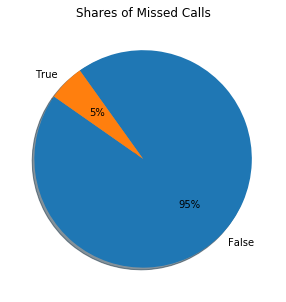

In [12]:
# plot pie chart with proportions
plt.figure(figsize=(10, 5))

missed_call_ratio = incoming_data.groupby('is_missed_call')['operator_id'].count().reset_index()
missed_call_ratio.columns = ['is_missed_call', 'count']

labels = ['False', 'True']
plt.pie(missed_call_ratio['count'], labels=labels,autopct='%0.f%%', shadow=True, startangle=145)
plt.title('Shares of Missed Calls')
plt.show()

This pie chart shows the share of missed calls and it shows that 95% of the calls are not missed.

#### Calculate average number of missed calls.

In [13]:
missed_calls = incoming_data['is_missed_call'].value_counts().reset_index()
missed_calls.columns = ['is_missed_call', 'count']

avg_missed_incoming_calls = missed_calls['count'][1] / missed_calls['count'][0]
print('The total average number of missed incoming calls: ' + str(avg_missed_incoming_calls))

The total average number of missed incoming calls: 0.057028514257128564


To calculate the average number of missed incoming calls, I divided the number of missed calls by the number of nonmissed calls. About 5.7% of the calls are missed.

#### Compare average missed calls of individual operators to the average of all operators.

In [14]:
# get data where missed calls is true
op_missed_calls = incoming_data[incoming_data['is_missed_call'] == True]
op_missed_calls = op_missed_calls.groupby('operator_id')['is_missed_call'].count().reset_index()
op_missed_calls.columns = ['operator_id', 'missed_call_count']

avg_missed_incoming_calls_per_op = op_missed_calls.mean()['missed_call_count'].round()

# calculate 1 sigma to use as a measure
wait_mean = op_missed_calls['missed_call_count'].mean()
wait_std = op_missed_calls['missed_call_count'].std()
sigma = wait_mean + (1 * wait_std)

# group rows into missed callcategories
def determineMissedCalls(row):
    missed_call = row['missed_call_count']
    
    # if  num of missed calls per op is less than avg
    if missed_call < sigma:
        return 'False'
    else:
        return 'True'
    
op_missed_calls['many_missed_calls'] = op_missed_calls.apply(determineMissedCalls, axis=1)
display(op_missed_calls[op_missed_calls['many_missed_calls'] == 'True'])

,operator_id,missed_call_count,many_missed_calls
5,885876,17,True
6,885890,21,True
22,893804,9,True
48,901880,10,True
82,908960,8,True
97,913938,13,True
98,913942,28,True
110,919206,7,True
113,919554,11,True
127,921818,9,True


To idenfity the operators with more than average number of missed calls, I calculated the average number of missed calls per operator and then compared the total average number of missed call per operator for that operator. An operator is given False under many_missed_calls column if their average number of missed calls is less than the total average number of missed calls.

### Outgoing Calls

#### Calculate the average number of outgoing calls.

In [15]:
# only outgoing direction
outgoing_data = data[data['direction'] == 'out']

avg_outgoing_per_op = outgoing_data['calls_count'].mean().round()
print('The average number of outgoing calls per operator is: ' + str(avg_outgoing_per_op))

The average number of outgoing calls per operator is: 21.0


To calculate the average number of outgoing calls per operator, I calculated the average number of calls for the out direction and determined that there is an average of 21 outgoing calls per operator,

#### Compare the average number of outgoing calls of individual operators to the average of all operators.

In [16]:
# calculate number of outgoing calls per operators
outgoing_per_op = outgoing_data.groupby('operator_id')['calls_count'].count().reset_index()
outgoing_per_op.columns = ['operator_id', 'total_calls_count']

# operators who are supposed to make outgoing calls are those with more than one outgoing call
outgoing_per_op = outgoing_per_op[outgoing_per_op['total_calls_count'] > 1]

# calculate 1 sigma to use as a measure
wait_mean = outgoing_per_op['total_calls_count'].mean()
wait_std = outgoing_per_op['total_calls_count'].std()
sigma = wait_mean + (1 * wait_std)

# group rows into missed callcategories
def determineOutgoingCalls(row):
    outgoing_call = row['total_calls_count']
    
    # if op num of outgoing calls is greater than avg
    if outgoing_call > wait_mean:
        return 'False'
    else:
        return 'True'
    
outgoing_per_op['few_outgoing_calls'] = outgoing_per_op.apply(determineOutgoingCalls, axis=1)
display(outgoing_per_op[outgoing_per_op['few_outgoing_calls'] == 'True'])

,operator_id,total_calls_count,few_outgoing_calls
2,880020,13,True
6,880240,12,True
7,881278,8,True
11,882688,7,True
15,883940,31,True
...,...,...,...
877,972408,2,True
878,972410,4,True
879,972412,4,True
880,972460,6,True


To identify the operators with less than average number of outgoing calls, I calculated the average number of outgoing calls per operator and then compared the total average number of missed calls per operator for that operator. An operator is given False under few_outgoing_calls if their average number of ouitgoing calls is greater than the total average number of outgoing calls.

### Determine the number of ineffective operators.

In [17]:
# combine dataframes
total_in_operators = pd.merge(op_missed_calls, op_waiting_time, on='operator_id')
total_in_operators = pd.merge(total_in_operators, outgoing_per_op, on='operator_id')

# identify ineffective ops for incoming calls
ineffective_incoming_ops = total_in_operators[(total_in_operators['many_missed_calls'] == 'True') & (total_in_operators['long_waiting_time'] == 'True')]
display(ineffective_incoming_ops)

# identify ineffective ops for outgoing calls
ineffective_outgoing_ops = total_in_operators[total_in_operators['few_outgoing_calls'] == 'True']
display(ineffective_outgoing_ops)

# concatenate results together
result = pd.concat([ineffective_incoming_ops, ineffective_outgoing_ops], ignore_index=True, sort=False)
display(result)

,operator_id,missed_call_count,many_missed_calls,in_waiting_time_sec,long_waiting_time,total_calls_count,few_outgoing_calls
73,913938,13,True,527.0,True,71,False
74,913942,28,True,348.0,True,50,False
87,919554,11,True,509.0,True,8,True
119,931458,10,True,709.0,True,88,False


,operator_id,missed_call_count,many_missed_calls,in_waiting_time_sec,long_waiting_time,total_calls_count,few_outgoing_calls
3,884408,3,False,66.0,False,11,True
7,888406,1,False,36.0,False,6,True
10,888868,1,False,31.0,False,18,True
15,890582,1,False,33.0,False,26,True
19,893402,3,False,68.0,False,35,True
...,...,...,...,...,...,...,...
188,959312,1,False,32.0,False,17,True
189,960620,1,False,75.0,False,18,True
190,964510,1,False,25.0,False,19,True
191,964666,2,False,64.0,False,13,True


,operator_id,missed_call_count,many_missed_calls,in_waiting_time_sec,long_waiting_time,total_calls_count,few_outgoing_calls
0,913938,13,True,527.0,True,71,False
1,913942,28,True,348.0,True,50,False
2,919554,11,True,509.0,True,8,True
3,931458,10,True,709.0,True,88,False
4,884408,3,False,66.0,False,11,True
...,...,...,...,...,...,...,...
76,959312,1,False,32.0,False,17,True
77,960620,1,False,75.0,False,18,True
78,964510,1,False,25.0,False,19,True
79,964666,2,False,64.0,False,13,True


An ineffective operator is defined as one that has a long waiting time (for both internal and external calls) and has many missed calls. Additionally, operators who make few outgoing calls (if they are supposed to) are considered ineffective.

I started by merging the tables containing information on operators with long wait time and operators with many missed calls. The operators who are identified as having many missed calls AND a long average waiting time are considered ineffective. This idenfitied 4 ineffective operators. 

Using outgoing data, the operators who were identified as having few outgoing calls counted up to 139 ineffective operators.

Out of the 1092 operators that the virtual telephone compares employs, I have identified a total of 143 ineffective ones as defined by their measures. 

### Investigate distribution of ineffective operators to tariff plans

In [18]:
# get operator id of ineffective operators
ineffective_op_id = result['operator_id']
ineffective_op_id.columns = ['operator_id']

# merge with bigger data set
data_ineffective = pd.merge(data, ineffective_op_id, on='operator_id')
total_ineffective_ops = data_ineffective['operator_id'].nunique()

# organize ineffective operators by tariff plan
tariff = data_ineffective.groupby('tariff_plan')['operator_id'].nunique().reset_index()
tariff.columns = ['tariff_plan', 'ineffective_operators']

# organize all operators by tariff plan
tariff_all = data.groupby('tariff_plan')['operator_id'].nunique().reset_index()
tariff_all.columns = ['tariff_plan', 'total_operators']
tariff['total_operators'] = tariff_all['total_operators']

# add the share of ineffective ops / total ops per tariff plan
tariff['op_share (%)'] = (tariff['ineffective_operators'] / tariff['total_operators'] * 100).round()
display(tariff)

,tariff_plan,ineffective_operators,total_operators,op_share (%)
0,A,21,310,7.0
1,B,26,395,7.0
2,C,33,387,9.0


We previously saw that most of the users are registered to tariff plan C, then plan B and the least amount of users are registered to plan A. Perhaps a pattern could have been spotted where operators are more likely to be ineffective when it comes to users who are registered to tariff plans A , since this is the least popular plan. The table shows that 15 percent of operators were ineffective for plan A (which makes sense since it is the least popular plan), 13 percent of operators were ineffective for plan B (which is of average popularity among users), and 12 percent of operators were ineffective for plan C which is the most popular plan. This difference could be explained by the larger number of users for tariff plan C, leads to the larger number of users calling in so more operators answer their calls. 

## Testing Hypothesis

### Test hypothesis: Average call duration for ineffective operators and effective operators are the same.

In [19]:
# Test hypothesis: Average call duration for ineffective operators and effective operators are the same.

# get operator id of ineffective operators
ineffective_op_id = result['operator_id'].to_numpy()

# get data relating to ineffective operators
ineffective_op_data = data[data['operator_id'].isin(ineffective_op_id)]

# calculate average call duration for ineffective ops
ineffective_call_duration_average = ineffective_op_data['call_duration_sec'].mean().round(decimals=2)

# find operator id of best operators 
effective_ops = total_in_operators[(total_in_operators['many_missed_calls'] == 'False') & (total_in_operators['long_waiting_time'] == 'False')]

# get operator id in best operators
effective_op_id = effective_ops['operator_id'].to_numpy()

# get data relating to best operators
effective_op_data = data[data['operator_id'].isin(effective_op_id)]

# calculate average call duration for ineffective ops
effective_call_duration_average = effective_op_data['call_duration_sec'].mean().round(decimals=2)

# perform a t-test
results = st.ttest_ind(effective_op_data['call_duration_sec'], ineffective_op_data['call_duration_sec'], equal_var=False)
p_value = results.pvalue
alpha = 0.05

if p_value < alpha:
    print('Reject H0')
else:
    print('Cannot reject H0')

Reject H0


We want to test the hypothesis that the average call duration for ineffective operators and effective operators are the same. We can do this using an independent samples t-test to compare the means from the two groups (ineffective operator average call duration and effective operator average call duration). We can apply a t-test here due to the Central Limit Theorem, which impliees that you can estimate the mean of a statistical population using the mean of a sample, and since the means are approximately normally distributed - we can use the t-test.

Null Hypothesis H0: The average call duration for ineffective operators and effective operators are the same.
Alternative Hypothesis H1: The average call duration for ineffective operators and effective operators are NOT the same.

The p_value suggests that we should reject the null hypothesis, thus indicating that the average call duration of ineffective operators and effective operators do differ enough to be statistically significant. This means that the sample results have a rare outcome and therefore it is very unlikely that to be just a lucky significance. This can be further proven by looking at the numbers: the average call duration of ineffective operators is 905 seconds (15 mins) and the average call duration of effective operators is 648 seconds (11 mins). 

## Conclusion

The task at hand was to identify ineffective operators based on the number of calls (incoming / outgoing), the waiting time for incoming calls and the number of outgoing calls (if the operator is supposed to make them).

According to the data, it was determined that:
- about 87% of calls found within the dataset are external calls.
- almost half of the calls are between 30 to 60 minutes but the next largest category are calls that lasted less than 1 minute.
- out of the three available plans, more than half of the users are subscribed to tariff C.
- almost 95% of calls are not missed calls. 
- there is an upward trend in the number of calls which could be because user registration increased over the same time period, thus increasing phone calls in order to keep up with demand.

For incoming calls, I needed to identify ineffective operators according to their wait time (if there is a large wait time for the operator to answer the phone) and according to the number of missed call (if there is a large number of missed calls). I applied the same method to identify operators where by finding the operators that were outside one standard deviation of the mean.
- For wait time, this method identified 22 operators with a long average wait time, their wait times ranged from 5 minutes to over 15 minutes.
- For missed calls, this method identified 24 operators with many missed calls, their number ranged from 7 to 28 missed calls per operator.

For outgoing calls, I needed to identify ineffective operators according to the number of outgoing calls they make (if they are supposed to make outgoing calls and they have a small number of outgoing calls). To do so, I found operators that were outside one standard deviation of the mean. This identified almost 500 ineffective operators with few outgoing calls.

According to the company’s definition, an ineffective operator is one who:
- Has a long wait time AND many missed calls (for incoming calls).
- Has few outgoing calls (for outgoing calls).

Out of the 1092 total operators, this logic identified a total of 143 ineffective operators as defined by the company’s measures:
- 4 operators ineffective for incoming calls.
- 139 operators ineffective for outgoing calls.

Action against the 4 ineffective operators for incoming calls should be taken immediately, as these operators have had a long average wait time and many missed calls over a 3 month period.

However, further analysis should be done for the 143 ineffective operators for outgoing calls. I do not believe that all of these operators are performing badly.

#### Link to powerpoint presentation: https://docs.google.com/presentation/d/19F8f_ARxiNgQwfpEPz4XuXkqIDDqaZwtTerBE7UsgkI/edit?usp=sharing